# Opt

この章では系の局所安定座標とそのエネルギーを計算する、 **構造最適化** (構造緩和などとも呼びます) について学びます。

最適化アルゴリズムには大域的最適化 (Global optimization)と、局所最適化(Local optimization)がありますが、構造最適化では局所最適化アルゴリズムを用います。


<figure>
    <img src="../assets/local-global-minimum.png" width="720px">
    <figcaption>ここでは横軸は系の様々な配座(Conformation) を表し、縦軸はエネルギーを表します。</figcaption>
</figure>

N個の原子からなる系の座標値は 3*N 次元の自由度があり、例えば100原子からなる系では300次元もの高次元空間での最適化問題となります。<br/>
大域最適解を見つけることは一般に難しい問題です。

構造最適化は、系の初期座標を定めて、そこから局所安定点を見つけることにより、その安定構造を見つけます。<br/>

ある物質の組成(元素の組み合わせとその割合、例えばNaCl など)がわかっている場合でも、その構造がどの様になっているかは自明ではありませんが、<br/>
物質の多くの性質が安定構造付近の状態から決まるため、安定構造を求めることは重要です。


実験的に構造を決定する場合は以下のような分析機器・計測装置を使う事が考えられます。
しかし、その場合でも

 - スペクトル情報から物質の部分的な情報が得られるのみで、3次元構造の情報が直接観測できるわけではない (1~6)
 - 単結晶や、薄膜といった構造を作成する必要があり、現実ではそういった試料の準備が難しいことがある (3, 8)
 - 原子レベルのスケールで見るには解像度が足りない (7)
 - 表面の形状は観察できるものの、その原子・分子の種類を区別することができない (9)

など、課題があり、今扱っている物質の各原子がどのように配置されているか、3次元構造の特定は容易ではありません。

分析機器の例：

| 名前 | 特徴 |
|:---|:---|
|1. 赤外分光法 |分子の振動による赤外線吸収を測定することで、分子構造の情報を得る |
|2. Raman分光法 |ラマン散乱光を用いて物質の評価を行う |
|3. X線回折法 (XRD: X-ray Diffraction) |結晶構造を持つ物質にX線を照射することで得られる回折線を解析することで物質の同定や定量を行う |
|4. X線光電子分光法 (XPS: X-ray Photoelectron Spectroscopy) |軟X線を物質に照射し、物質のイオン化に伴い放出される光電子e-を補足しエネルギー分析を行う |
|5. 質量分析計 (MS: Mass Spectroscopy) |物質を構成している個々の化合物の質量を正確に測定 |
|6. 核磁気共鳴装置 (NMR: Nuclear Magnetic Resonance) | 原子核の共鳴現象を利用して、有機化合物の分析を行う |
|7. 走査電子顕微鏡 (SEM: Scanning Electron Microscope) | 波長の短い電子線を利用して0.4~4nmの解像度で表面を観察 |
|8. 透過電子顕微鏡 (TEM: Transmission Electron Microscope) |電子線を当て透過した電子線の強弱により微小な物質を観察 |
|9. 原子間力顕微鏡 (AFM: Atomic Force Microscope) | 探針と試料に作用する原子間力を検出する顕微鏡 |


分析機器の参考文献

 - [やさしい科学 | JEOL 日本電子株式会社](https://www.jeol.co.jp/science/)
 - [分析の原理 | JAIMA 一般社団法人 日本分析機器工業会](https://www.jaima.or.jp/jp/analytical/basic/)
 - [分析装置 | 環境リサーチ株式会社](https://www.kankyo-research.co.jp/equipment/)
 - [MST｜分析手法](https://www.mst.or.jp/method/tabid/64/Default.aspx)


そのため、シミュレーション上でどの構造になっていそうかを推定し、実験で検証する（またはその逆）を行うことが重要となります。


## Opt molecules
まずは簡単な例として、周期境界条件のない単体の有機分子の構造最適化を行ってみます。


### 1. 水素分子

まずは、前章でも行った水素分子の最安定構造の結合距離を、構造最適化を用いて求めてみます。

以下のような流れとなります。

 - Step 1: ポテンシャルエネルギーを計算するCalculatorを用意
 - Step 2: 構造最適化を行いたい分子を用意
 - Step 3: 構造最適化アルゴリズムの手法を選択し、実行


Step 1: ポテンシャルエネルギーを計算するCalculatorを用意

In [1]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


print(f"pfp_api_client: {pfp_api_client.__version__}")

estimator = Estimator(calc_mode=EstimatorCalcMode.MOLECULE, model_version="v2.0.0")
#estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.3.1


※PFP `Estimator` の `calc_mode` は以下のように用います。

 - 一般の系： `EstimatorCalcMode.CRYSTAL_U0` Uなしモード
 - 酸化物など： `EstimatorCalcMode.CRYSTAL`　Uありモード
 - 単体有機分子： `EstimatorCalcMode.MOLECULE` 分子モード

Step 2: 構造最適化を行いたい分子を用意

ここでは水素分子を作成します。座標値は人手で、1.0A 離れたところで初期座標を設定してみます。

In [2]:
from ase import Atoms


atoms = Atoms("H2", [[0, 0, 0], [0, 0, 1.0]])
atoms.calc = calculator

Step 3: 構造最適化アルゴリズムの手法を選択し、実行

局所最適化アルゴリズムとして、ASEではNewton法に似た振る舞いで最適化を行う `FIRE`, `MDMin` や、2次関数近似をおこなって最適化を行う `BFGS`, `LBFGS`, `BFGSLineSearch`=`QuasiNewton`, `LBFGSLineSearch`法などが提供されています。これらのアルゴリズムの違いや性質については次章で説明をします。

 - https://wiki.fysik.dtu.dk/ase/ase/optimize.html


今回は、`LBFGS` を用いて構造最適化を行ってみます。<br/>
基本的には `atoms` を局所最適化アルゴリズムに設定し、 `run`関数を呼ぶと構造最適化が行われます。<br/>
`trajectory` 引数を指定しておくと、構造最適化の過程を保存できます。

In [3]:
import os
from ase.optimize import LBFGS, BFGS, FIRE

os.makedirs("output", exist_ok=True)

opt = LBFGS(atoms, trajectory="output/bfgs_h2.traj")
opt.run(fmax=0.01)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:12:58       -3.901997*       4.3815
LBFGS:    1 04:12:58       -4.379254*       2.9801
LBFGS:    2 04:12:58       -4.203410*       8.1743
LBFGS:    3 04:12:58       -4.556839*       2.0679
LBFGS:    4 04:12:58       -4.621649*       1.1575
LBFGS:    5 04:12:58       -4.633657*       0.8236
LBFGS:    6 04:12:58       -4.641413*       0.0730
LBFGS:    7 04:12:58       -4.641474*       0.0016


True

今回の簡単な例では 7step、Matlantis では約2秒で構造最適化が終了しました。

構造最適化途中の系の可視化を行ってみます。

In [4]:
from ase.visualize import view
from ase.io import Trajectory
from pfcc_extras.visualize.view import view_ngl

traj = Trajectory("output/bfgs_h2.traj")
view_ngl(traj, representations=["ball+stick"], w=400, h=300)

構造最適化により、原子距離がどのように推移したかをプロットしてみます。

In [5]:
import numpy as np

# np.linalg.norm?
distance_list = []
E_pot_list = []
for atoms in traj:
    p1, p2 = atoms.get_positions()
    distance = np.linalg.norm(p1 - p2)
    distance_list.append(distance)
    E_pot_list.append(atoms.get_potential_energy())

print("Distance trajectory", distance_list)

Distance trajectory [1.0, 0.87481564113072, 0.6086009335795225, 0.8036915804734652, 0.7643025335702752, 0.7142209165568315, 0.7350406565664916, 0.7333450580696154]


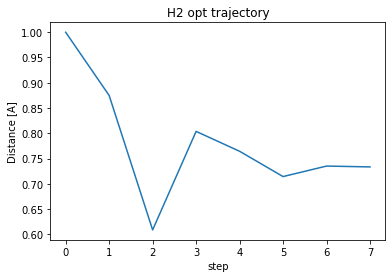

In [6]:
import matplotlib.pyplot as plt
plt.plot(distance_list)
plt.xlabel("step")
plt.ylabel("Distance [A]")
plt.title("H2 opt trajectory")
plt.show()

最終的に、 `0.73` A あたりで落ち着くことが確認できました。

前章ではすべての結合距離に対するエネルギーを計算し、最低エネルギーになる値を求めましたが、構造最適化を用いることで効率よく安定構造を見つけることができます。

### 2. シクロヘキサン

次の例として、シクロヘキサンの安定構造を考えてみます。<br/>

シクロヘキサンはC6H12で表される構造ですが、いくつかの立体配座(Conformation) を取ることが知られています。<br/>
代表的な配座異性体としては、以下の図のいす形 (A)、ねじれ舟形 (B)、舟形 (C)、半いす形 (D)などがあります。

一番安定な（エネルギーの低い）形はいす形で、25℃ではシクロヘキサン溶液中の全分子の99.99%がいす形になります。<br/>
ここでは、いす形 (A)および、舟形 (C)の初期構造を用意して、構造最適化を行い、その形やポテンシャルエネルギーを比較してみます。

<figure style="width:600px">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Cyclohexane_ring_flip_and_relative_conformation_energies.svg"/>
</figure>

<cite><a href="https://ja.wikipedia.org/wiki/%E3%82%B7%E3%82%AF%E3%83%AD%E3%83%98%E3%82%AD%E3%82%B5%E3%83%B3%E3%81%AE%E7%AB%8B%E4%BD%93%E9%85%8D%E5%BA%A7">
シクロヘキサンの立体配座</a> より</cite>



**初期座標の構造用意**

いす形はPubChemで公開されている構造を使用します。

3D structure image of CID 8078 Cyclohexane (Compound)

PubChem Identifier: CID 8078<br/>
URL: https://pubchem.ncbi.nlm.nih.gov/compound/8078#section=3D-Conformer


In [7]:
from ase.io import read

chair_atoms = read("../input/Conformer3D_CID_8078.sdf")
view_ngl(chair_atoms, representations=["ball+stick"], w=400, h=300)

舟形は今回は、いす形から座標値を手動で変更して生成してみましょう。<br/>
※: コードの意味はわからなくてもスキップしていただいて構いません。(原子を180度回転させたものをつくり、原子2, 10, 11のみ回転させた座標のものに上書きしています。)

In [8]:
boat_atoms = chair_atoms.copy()
axis = boat_atoms.positions[[1, 5]].mean(axis=0) - boat_atoms.positions[[0, 4]].mean(axis=0)
boat_atoms.rotate(180, axis)
# inds = [1, 3, 5, 8, 9, 12, 13, 16, 17]
inds = [2, 10, 11]
boat_atoms.positions[inds] = chair_atoms.positions[inds]

In [9]:
view_ngl(boat_atoms, representations=["ball+stick"], w=400, h=300)

In [10]:
chair_atoms.calc = calculator
opt = LBFGS(chair_atoms, trajectory="output/lbfgs_cyclohexane_chair.traj")
opt.run()

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:13:37      -76.902433*       0.1633
LBFGS:    1 04:13:37      -76.904415*       0.1067
LBFGS:    2 04:13:37      -76.906113*       0.0945
LBFGS:    3 04:13:37      -76.908255*       0.0431


True

In [11]:
boat_atoms.calc = calculator
opt = LBFGS(boat_atoms, trajectory="output/lbfgs_cyclohexane_boat.traj")
opt.run()

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:13:38      -70.864456*       6.1915
LBFGS:    1 04:13:38      -72.338200*       4.7000
LBFGS:    2 04:13:38      -74.264803*       3.1249
LBFGS:    3 04:13:38      -75.165260*       4.2943
LBFGS:    4 04:13:38      -75.636212*       2.8085
LBFGS:    5 04:13:38      -75.792037*       2.3032
LBFGS:    6 04:13:38      -75.910488*       2.0220
LBFGS:    7 04:13:38      -76.152622*       0.8425
LBFGS:    8 04:13:38      -76.226800*       0.6651
LBFGS:    9 04:13:38      -76.319684*       0.7879
LBFGS:   10 04:13:38      -76.369102*       0.7891
LBFGS:   11 04:13:38      -76.442902*       0.5855
LBFGS:   12 04:13:38      -76.483407*       0.5161
LBFGS:   13 04:13:38      -76.503122*       0.2676
LBFGS:   14 04:13:38      -76.512001*       0.2615
LBFGS:   15 04:13:39      -76.521395*       0.2402
LBFGS:   16 04:13:39      -76.528727*       0.1844
LBFGS:   17 04:13:39      -76.5334

True

構造最適化後の構造を可視化して確認してみましょう。

In [12]:
view_ngl([chair_atoms, boat_atoms], representations=["ball+stick"], w=400, h=300, replace_structure=True)

また、それぞれのエネルギー差を比較してみます。

エネルギーの単位はeVですが、単位の変換する場合、`units` module を用いることができます。

 - https://wiki.fysik.dtu.dk/ase/ase/units.html


In [13]:
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal

E_chair = chair_atoms.get_potential_energy()
E_boat = boat_atoms.get_potential_energy()

E_diff = E_boat - E_chair

print(f"E_chair {E_chair:.2f} eV")
print(f"E_boat  {E_boat:.2f} eV")
print(f"E_diff  {E_diff:.2f} eV = {E_diff / (kJ/mol):.2f} kJ/mol")

E_chair -76.91 eV
E_boat  -76.64 eV
E_diff  0.27 eV = 25.82 kJ/mol


いす形の方が舟形よりもエネルギーが低く、安定であることがわかりました。<br/>
また、そのエネルギー差も上図で示されていた25kJ/mol に近い値を得ることができました。


このように構造最適化では、局所安定点を求めるため、初期構造が重要となってきます。<br/>
(おなじシクロヘキサンでも初期構造の用意の仕方によって構造最適化後の結果が異なります。)

## Opt Crystals

次に周期構造のある系に対する構造最適化を行ってみます。<br/>
上記の周期構造がない有機分子では各原子の座標のみが最適化対象でしたが、周期系では**セルサイズ** も最適化対象に加わります。

また、周期構造を持つ結晶系 (Bulk)では、その結晶構造によりエネルギーが異なります。


### 1. Si結晶

ここではSiの結晶構造として、どのような構造がエネルギー安定となるのかを調べてみましょう。<br/>
結晶構造の候補として、以下のような構造を試してみます。

 - sc: 単純立方格子 (Simple Cubic)
 - bcc: 体心立方格子 (Body Centered Cubic)
 - fcc: 面心立方格子 (Face Centered Cubic)
 - hcp: 六方最密充填構造 （Hexagonal Close Packed)
 - diamond: ダイヤモンド構造

エネルギーは１原子あたりのエネルギーを算出します。

まず、Si のBCC構造に対し、その格子定数 `a` を様々な値に変えた場合のポテンシャルエネルギー及びその時の密度 (density) を計算するコードは以下のようになります。

ここでは、`np.linspace` 関数を用いて格子定数 `a` を 2.5A から7.0A の間で5つ生成し、それぞれの格子定数におけるエネルギーを求めています。

In [14]:
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v2.0.0")
calculator = ASECalculator(estimator)

In [15]:
from ase.build import bulk


a_array = np.linspace(2.5, 7.0, 5)

bcc_energy_list = []
bcc_density_list = []
for a in a_array:
    atoms = bulk("Si", "bcc", a=a)
    atoms.calc = calculator
    # calculate potential energy for 1 atom (eV/atom)
    E_pot = atoms.get_potential_energy() / len(atoms)
    density = len(atoms) / atoms.get_volume()
    bcc_energy_list.append(E_pot)
    bcc_density_list.append(atoms.get_volume())
    
print("lattice a: ", list(a_array))
print("Density  : ", bcc_density_list)
print("Energy   : ", bcc_energy_list)

lattice a:  [2.5, 3.625, 4.75, 5.875, 7.0]
Density  :  [7.8125, 23.817382812499996, 53.58593750000001, 101.38964843749996, 171.50000000000006]
Energy   :  [-1.0654683418833883, -3.367653043475002, -1.242994012311101, -0.19300098989333492, -0.0252915620803833]


今回は、様々な構造に対して計算を行うため、これを関数化してみましょう。

In [16]:
from ase.build import bulk

def calc_density_energy(calculator, symbol: str = "Fe", crystalstructure: str = "bcc"):
    a_array = np.linspace(2.0, 8.0, 30)

    energy_list = []
    density_list = []
    for a in a_array:
        atoms = bulk(symbol, crystalstructure, a=a)
        atoms.calc = calculator
        E_pot = atoms.get_potential_energy() / len(atoms)
        density = len(atoms) / atoms.get_volume()
        energy_list.append(E_pot)
        density_list.append(density)
    return np.array(energy_list), np.array(density_list)

この `calc_density_energy` 関数を用いることで、様々な構造に対するエネルギーと密度のリストを得ることができます。

In [17]:
bcc_energy, bcc_density = calc_density_energy(calculator, "Si", "bcc")
fcc_energy, fcc_density = calc_density_energy(calculator, "Si", "fcc")
sc_energy, sc_density = calc_density_energy(calculator, "Si", "sc")
hcp_energy, hcp_density = calc_density_energy(calculator, "Si", "hcp")
diamond_energy, diamond_density = calc_density_energy(calculator, "Si", "diamond")

計算されたエネルギー値を見てみると、`a`の値が小さすぎる場合 (現実的でないほど密度を大きくしてしまった場合)にはエネルギーの値が不安定に出力されてしまっていることがわかります。

In [18]:
bcc_energy

array([ 1.79088160e+13,  2.10909171e+01,  1.40880359e+00, -2.60080929e+00,
       -3.72749183e+00, -4.02926029e+00, -3.91744089e+00, -3.64932736e+00,
       -3.31192013e+00, -2.92009913e+00, -2.53565391e+00, -2.11843024e+00,
       -1.69025610e+00, -1.32619862e+00, -1.05229570e+00, -7.91154718e-01,
       -5.65129866e-01, -3.96760291e-01, -2.68894639e-01, -1.71354900e-01,
       -1.15107699e-01, -7.68998740e-02, -4.47715558e-02, -2.66301780e-02,
       -2.52915621e-02, -2.52915621e-02, -2.52915621e-02, -2.52915621e-02,
       -2.52915621e-02, -2.52915621e-02])

以下はこのような値は避けて、プロットを行っています。

`np.where`関数を使って、絶対値が5以下になっているエネルギーをとっているindex を`inds` としてとりだし、`a_array[inds]`でハズレ値を除いたプロットを行っています。

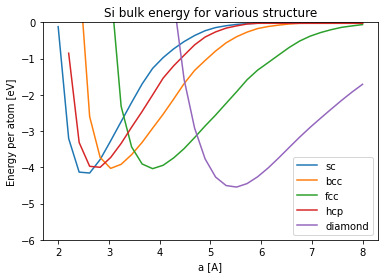

In [19]:
a_array = np.linspace(2.0, 8.0, 30)
inds = np.where(np.abs(sc_energy) < 5.0)[0]
plt.plot(a_array[inds], sc_energy[inds], label="sc")
inds = np.where(np.abs(bcc_energy) < 5.0)[0]
plt.plot(a_array[inds], bcc_energy[inds], label="bcc")
inds = np.where(np.abs(fcc_energy) < 5.0)[0]
plt.plot(a_array[inds], fcc_energy[inds], label="fcc")
inds = np.where(np.abs(hcp_energy) < 5.0)[0]
plt.plot(a_array[inds], hcp_energy[inds], label="hcp")
inds = np.where(np.abs(diamond_energy) < 5.0)[0]
plt.plot(a_array[inds], diamond_energy[inds], label="diamond")

plt.xlabel("a [A]")
plt.ylabel("Energy per atom [eV]")
plt.legend()
plt.title("Si bulk energy for various structure")

plt.ylim(-6.0, 0)
#plt.yscale("log")
plt.show()

上図は格子定数`a`を横軸にとっていますが、この場合は構造ごとにエネルギーが小さくなる位置が異なり比較しづらい事がわかります。

下図では、密度を横軸にとって、エネルギーをプロットしてみます。

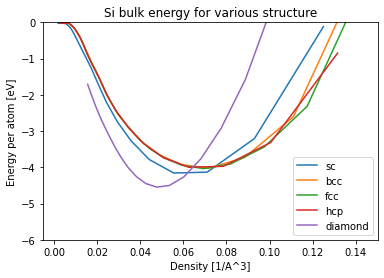

In [20]:
inds = np.where(np.abs(sc_energy) < 5.0)[0]
plt.plot(sc_density[inds], sc_energy[inds], label="sc")
inds = np.where(np.abs(bcc_energy) < 5.0)[0]
plt.plot(bcc_density[inds], bcc_energy[inds], label="bcc")
inds = np.where(np.abs(fcc_energy) < 5.0)[0]
plt.plot(fcc_density[inds], fcc_energy[inds], label="fcc")
inds = np.where(np.abs(hcp_energy) < 5.0)[0]
plt.plot(hcp_density[inds], hcp_energy[inds], label="hcp")
inds = np.where(np.abs(diamond_energy) < 5.0)[0]
plt.plot(diamond_density[inds], diamond_energy[inds], label="diamond")

plt.xlabel("Density [1/A^3]")
plt.ylabel("Energy per atom [eV]")
plt.legend()
plt.title("Si bulk energy for various structure")

plt.ylim(-6.0, 0)
#plt.yscale("log")
plt.show()

密度を横軸に取ることで見やすい図になりました。

このように、格子定数を変えながら計算をすることで、SC, BCC, FCC, HCP, Diamondそれぞれの構造でエネルギーが最小になりそうな格子定数を求めることができます。<br/>
今回の計算結果で、それぞれの構造に対する最低エネルギーを比較することで、**Si はDiamondが安定である**ということが分析できました。

### 2. Fe結晶の格子定数最適化

次は、この格子定数を構造最適化アルゴリズムを用いることにより、効率よく求めてみましょう。

周期構造のある系の最適化を行う際には、原子座標のみを最適化するのか、**Cell sizeも含めて**最適化するのかによりその方法が異なります。<br/>
Cell も最適化の対象としたい場合、ASE のatomsに対して、以下に示すような Filter クラスを適用する必要があります。


**Table: 最適化対象と、使用するFilter**

|  Position  | Cell | Filter |
| ---- | ---- | ---- |
|  ✓  |    | 不要 (Default挙動) |
|    |  ✓  | `StrainFilter` |
|  ✓  |  ✓  | `ExpCellFilter` or `UnitCellFilter` |

1. 座標は固定して、CellのみをOpt --> `StrainFilter`
2. Cell固定して+座標のみをOpt --> Filter未使用
3. Cell+座標両方をOpt --> `ExpCellFilter`


まずはじめに`StrainFilter`を使う例を紹介します。

ここではFe原子のBCC構造・FCC構造の格子定数を最適化してみます。<br/>
BCC構造・FCC構造はprimitive cellに原子が１つしか含まれないため、原子座標を最適化する必要はなく、格子定数のみの最適化を行えば十分なため、`StrainFilter`を用いています。

In [21]:
from ase.constraints import ExpCellFilter, StrainFilter

fe_bcc_atoms = bulk("Fe", "bcc", a=3.0)
print("Before opt:", fe_bcc_atoms.cell)
fe_bcc_atoms.calc = calculator

fe_bcc_atoms = StrainFilter(fe_bcc_atoms)
opt = LBFGS(fe_bcc_atoms, trajectory="output/lbfgs_fe_bcc.traj")
opt.run()

Before opt: Cell([[-1.5, 1.5, 1.5], [1.5, -1.5, 1.5], [1.5, 1.5, -1.5]])
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:14:05       -4.892960*       2.5421
LBFGS:    1 04:14:05       -4.961273*       1.3053
LBFGS:    2 04:14:05       -4.992595*       0.2788
LBFGS:    3 04:14:05       -4.993966*       0.0337


True

In [22]:
from ase.constraints import ExpCellFilter, StrainFilter

fe_fcc_atoms = bulk("Fe", "fcc", a=3.0)
print("Before opt:", fe_fcc_atoms.cell)
fe_fcc_atoms.calc = calculator

fe_fcc_atoms = StrainFilter(fe_fcc_atoms)
opt = LBFGS(fe_fcc_atoms, trajectory="output/lbfgs_si_fcc.traj")
opt.run()

Before opt: Cell([[0.0, 1.5, 1.5], [1.5, 0.0, 1.5], [1.5, 1.5, 0.0]])
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:14:05       -2.629525*      29.6136
LBFGS:    1 04:14:06       -4.778833*       3.5812
LBFGS:    2 04:14:06       -4.847243*       2.0166
LBFGS:    3 04:14:06       -4.883184*       0.4186
LBFGS:    4 04:14:06       -4.885321*       0.1172
LBFGS:    5 04:14:06       -4.885510*       0.0044


True

In [23]:
fe_bcc_atoms.atoms.cell

Cell([[-1.426341413219274, 1.4263413699752452, 1.426341410873824], [1.426341383155157, -1.426341375930719, 1.4263413867651806], [1.4263414132520593, 1.4263413759635044, -1.4263414168292976]])

In [24]:
fe_fcc_atoms.atoms.cell

Cell([[-8.797872643650706e-09, 1.7389138170758964, 1.738913832253837], [1.7389138462808902, 5.4777854905078855e-09, 1.738913817978179], [1.738913848567748, 1.7389138050870963, 3.1909274670322165e-09]])

`StrainFilter`を用いて格子定数の最適化を行った場合、結晶のa, b, c軸の対称性を保つ考慮がされないためそれぞれ値が少し違った値となってしまっています。<br/>
実際は後述する`ExpCellFilter` や、`FixSymmetry` を活用することで、対称性を保ったままの最適化も可能です。

ここでは、最終的な格子定数を計算するために平均値をとることにします。<br/>
ASEの`bulk` methodに指定する引数 `a` に対して、BCC構造のセルは

```
[[-a/2, a/2, a/2],
 [a/2, -a/2, a/2],
 [a/2, a/2, -a/2]]
```

FCC構造のセルは
```
[[0, a/2, a/2],
 [a/2, 0, a/2],
 [a/2, a/2, 0]]
```
となっていることを用いて、下記の計算を行っています。

In [25]:
a = np.abs(fe_bcc_atoms.atoms.cell).mean() * 2
E_pot = fe_bcc_atoms.get_potential_energy()
print(f"BCC opt: a = {a:.2f} A, E = {E_pot:.2f} eV")

a = fe_fcc_atoms.atoms.cell.sum() / 3
E_pot = fe_fcc_atoms.get_potential_energy()
print(f"FCC opt: a = {a:.2f} A, E = {E_pot:.2f} eV")

BCC opt: a = 2.85 A, E = -4.99 eV
FCC opt: a = 3.48 A, E = -4.89 eV


構造最適化の結果として、BCC構造では `a=2.85` A のときにエネルギーが最小となる事がわかりました。

また、**FeはBCC構造のほうがFCC構造よりも安定である**という、実験結果と整合する結果を得ることができました。

構造最適化の途中経過を可視化してみると、原子座標は変わらずに、格子定数のみが最適化されていることが確認できます。

In [26]:
view_ngl(Trajectory("output/lbfgs_fe_bcc.traj"), w=400, h=300, replace_structure=True)

`StrainFilter`を使う場合の注意点として、セルのa, b, c軸が独立して最適化されてしまうため、その比率を保ちたい場合にも保たれない可能性があります。

### 3. Si結晶diamond 構造の格子定数最適化

次に、Si結晶のdiamond構造に対して、最適化を行ってみます。<br/>
ここでは、原子座標及びセルサイズ双方を最適化する`ExpCellFilter` を使用してみます。

`ExpCellFilter`では、`hydrostatic_strain=True`というOptionをつけることによって、セルのa, b, c軸長さの比率を保ったまま最適化が行なえます。

In [27]:
from ase.constraints import ExpCellFilter, StrainFilter

si_diamond_atoms = bulk("Si", "diamond")
si_diamond_atoms.calc = calculator

print("cell size before: ", si_diamond_atoms.cell)
si_diamond_atoms = ExpCellFilter(si_diamond_atoms, hydrostatic_strain=True)
opt = LBFGS(si_diamond_atoms, trajectory="output/lbfgs_si_diamond.traj")
opt.run()

print("cell size after : ", si_diamond_atoms.atoms.cell)

cell size before:  Cell([[0.0, 2.715, 2.715], [2.715, 0.0, 2.715], [2.715, 2.715, 0.0]])
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:14:25       -9.092463*       0.4849
LBFGS:    1 04:14:25       -9.097615*       0.0140
cell size after :  Cell([[0.0, 2.733871091154804, 2.733871091154804], [2.733871091154804, 0.0, 2.733871091154804], [2.733871091154804, 2.733871091154804, 0.0]])


cell sizeのbefore, after を見比べると、セルサイズの比率が保たれたまま、構造緩和を行えたことがわかります。

In [28]:
view_ngl(Trajectory("output/lbfgs_si_diamond.traj"), w=400, h=300, replace_structure=True)

### 4. SiO2 結晶

これまでは1元素のみを含む結晶を扱ってみました。最後に実用的な例として、SiO2結晶についての最適化を行ってみます。

SiO2は、現実でも[Quartz (石英)](https://ja.wikipedia.org/wiki/%E7%9F%B3%E8%8B%B1), [Cristobalite](https://ja.wikipedia.org/wiki/%E3%82%AF%E3%83%AA%E3%82%B9%E3%83%88%E3%83%90%E3%83%A9%E3%82%A4%E3%83%88), [Tridymite (鱗珪石)](https://ja.wikipedia.org/wiki/%E9%B1%97%E7%8F%AA%E7%9F%B3)といった、様々な構造を取ることが知られています。<br/>
このように同じ組成で多くの結晶系が存在することを[多形](https://ja.wikipedia.org/wiki/%E5%A4%9A%E5%BD%A2)と呼びます。

今回は、Quartz構造をMaterials projectから用意し、構造最適化を行っています。<br/>
座標値・セルサイズ双方を同時に最適化するため、`ExpCellFilter` を用いています。

Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [29]:
atoms = read("../input/SiO2_mp-6930_conventional_standard.cif")
atoms.calc = calculator

view_ngl(atoms, representations=["ball+stick"])

In [30]:
opt = LBFGS(ExpCellFilter(atoms), trajectory="output/lbfgs_sio2.traj")
opt.run()

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:14:52      -57.053849*       0.2183
LBFGS:    1 04:14:52      -57.050798*       0.9588
LBFGS:    2 04:14:52      -57.054328*       0.0523
LBFGS:    3 04:14:52      -57.054585*       0.0470


True

In [31]:
view_ngl(Trajectory("output/lbfgs_sio2.traj"), representations=["ball+stick"])

**[Note] 構造最適化はCalculator (Potential energyの関数系)が変わる度に必要**

Materials projectの構造も、構造最適化を行った構造であるため、すでに完全な安定構造かと思うかもしれません。
しかし、厳密な局所点(極小のエネルギーを取る構造)は、ポテンシャルエネルギーが変わると異なります。

## [コラム] 構造最適化計算と現実世界

この章で紹介した構造最適化計算は、今後紹介するほぼすべての原子シミュレーションにとって土台となる計算となります。しかし、構造最適化計算の内部で使われている計算手法はいくらか技巧的なものであり、このチュートリアルではじめて原子シミュレーションに触れた人にとっては直感的には必要性がわかりにくいかもしれません。そこでこのコラムでは、現実世界との対応関係という観点から構造最適化計算を見直してみます。

### 構造最適化の必要性

現実世界の物質の原子配置がどのように決まっているかについて考えてみますと、一つ一つの原子は特に拘束もなく自由に動き回っているので、余計なエネルギーは散逸し、エネルギーの低い安定な構造へと変化していきます。一旦温度の影響を無視して十分に温度が低い場合を考えてみると、その場合は原子の運動エネルギーは0になり、ポテンシャルエネルギーは極小値をとることが考えられます。その意味では構造最適化計算は現実世界における絶対零度の状態を考えていることに対応しています。

有限温度の場合にはどうでしょうか。統計力学の理論から、平衡状態にある系では温度と運動エネルギーは一定の関係にあることが知られており、大雑把な計算では1 Kの上昇はおおまかに1/10000 eV/atomの運動エネルギーの上昇に相当します。逆にいうと、1 eV/atomのエネルギーの上昇は温度に換算して10000 K程度の構造に相当するということです。このように有限温度の場合でもしばしばエネルギーを最適化した構造が十分に良い近似となることが多いため、シミュレーションのはじめにまずは構造最適化計算をしよう(有限温度の場合にはその後で温度を上昇させよう)という手順をとることが一般に行われています。

構造最適化計算を行わずにシミュレーションをしてしまうと、前提条件の違いにより非現実的な結果をもたらしてしまう可能性があります。例えば鉄の結晶構造を1%小さくとった場合、原子構造を可視化しただけであれば特段の変化は見えないかもしれません。しかし現実世界で鉄を1%縮める操作を考えてみればわかるように、これは非常に強い圧縮力(具体的には1 GPaを超える圧力)のかかった鉄に相当するので、シミュレーションの結果を変えてしまうことが想定されます。

### 構造最適化手法と現実世界の構造緩和

構造最適化計算の種類がたくさんあることについて、現実世界との対応から考えてみます。適当な温度の高い材料、例えば溶けた鉄について、ここから熱を取り除いて少し冷えていくときに起きる現象を考えてみましょう。鉄原子は熱によって常に振動しており、様々な原子配置をとりながら、少しずつポテンシャルエネルギーの低い構造へと遷移していきます。最終的にはエネルギーの低い、原子がきれいに整列した結晶構造へと遷移していきます。この意味では現実世界における構造最適化は[焼きなまし法](https://ja.wikipedia.org/wiki/%E7%84%BC%E3%81%8D%E3%81%AA%E3%81%BE%E3%81%97%E6%B3%95)(SA: Simulated Annealing)と呼ばれる最適化手法の一種とみなすことができます。(歴史的には、こちらが焼きなまし法のアイデア元に相当します。)

これは原子が長時間運動した結果として得られるものです。つまり、原理的には原子シミュレーションでも、十分に長い分子動力学計算が行えれば現実世界と同じように安定な構造が得られることを意味しています。

しかし、ここで問題になるのが時間スケールのギャップです。原子の動きは典型的にはフェムト秒($10^{-15}$ s)オーダーの現象ですが、現実世界の材料を考えるときは一般にはるかに長い時間スケールが登場します。このため、現実世界の構造を原子スケールシミュレーションの言葉で書き直すと、$10^{15}$やそれ以上のスケールでの極めて長い時間をかけた構造最適化計算の結果とみなすことができます。また、焼きなまし法はロバスト性の高い最適化手法であり、十分に長い時間をかけることでより大域的な最適解へとたどり着くことが知られています。このため、現実に存在する物質は実質的に大域最適化問題が解かれた原子構造が得られていると考えることができます。

このようなことから、原子シミュレーションでも短時間でより大域的な最適解を探すことができる手法が開発されてきました。これは一般に計算時間とのトレードオフとなるため、ケースによって使い分けられます。結晶構造のように目的の構造が既にわかっていて十分に近い構造を初期構造としてとれる場合には、上の例にあるBFGS法のように局所最適解を求める手法が好まれます。逆にアモルファス構造のようによくわからない構造を対象とする場合には、より大域的な最適解を求めるためにより注意が向けられます。(より現実的になるよう、ゆっくりと温度を下げていくメルトクエンチ法などが使われます。)ASEを含む原子シミュレーションのライブラリに様々な最適解手法が搭載されているのはこのためです。

余談ですが、実は現実世界でも大域最適解になりきらないケースは存在します。例えば炭素の高圧相であるダイヤモンドは地上では安定ではなく、黒鉛(グラファイト)のほうがより安定なのですが、構造変化に必要なエネルギーが高いため構造が変化する速度が極めて遅く、人間の時間スケールでは実質的に安定な構造(準安定状態)として扱われます。製造時に積極的に利用している有名な例としては鉄の焼入れがあります。日本刀を作るときに熱した鉄を水に漬けることで硬くする技術が有名ですが、温度を急冷させることで構造緩和にかかる時間を短縮し、安定構造に遷移することを防いでいます。これによってより都合の良い準安定状態を得ています。
このように、相変態や化学変化を伴う現象には日常スケールでも緩慢に起きる場合が多いです。これは原子シミュレーションでも同様で、相変態や化学反応を見たい場合には単純に長時間の動力学計算を行うよりも効率的な計算手法が使われることがあります。ひとつの具体例として、5章で説明があるNEB法があります。